In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy
import os
from tqdm import tqdm



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
data_dir = r"D:\iot\leaf_dataset"

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}


In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),
                                         transform=data_transforms[x])
                 for x in ['train','val','test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
               for x in ['train','val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val','test']}
class_names = image_datasets['train'].classes
print("Classes:", class_names)


Classes: ['Disease', 'Dry', 'Healthy']


In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)  


In [ ]:
def train_model(model, criterion, optimizer, num_epochs=20):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        for phase in ['train','val']:
            if phase=='train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            loop = tqdm(dataloaders[phase], desc=f"{phase} Epoch {epoch+1}")
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)

                loop.set_postfix(loss=loss.item())

            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase=='val' and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase=='train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

    print(f"\n Best Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history


In [8]:
model, train_hist, val_hist = train_model(model, criterion, optimizer, num_epochs=20)



Epoch 1/20


train Epoch 1:   0%|          | 0/318 [00:00<?, ?it/s]

train Epoch 1: 100%|██████████| 318/318 [07:58<00:00,  1.50s/it, loss=0.136]   


train Loss: 0.0810 Acc: 0.9744


val Epoch 1: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s, loss=0.0411] 


val Loss: 0.0596 Acc: 0.9835

Epoch 2/20


train Epoch 2: 100%|██████████| 318/318 [08:01<00:00,  1.51s/it, loss=0.0482]  


train Loss: 0.0298 Acc: 0.9906


val Epoch 2: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s, loss=0.00815] 


val Loss: 0.0344 Acc: 0.9898

Epoch 3/20


train Epoch 3: 100%|██████████| 318/318 [07:59<00:00,  1.51s/it, loss=0.00371] 


train Loss: 0.0286 Acc: 0.9909


val Epoch 3: 100%|██████████| 40/40 [00:27<00:00,  1.46it/s, loss=0.138]   


val Loss: 0.0184 Acc: 0.9937

Epoch 4/20


train Epoch 4: 100%|██████████| 318/318 [07:50<00:00,  1.48s/it, loss=0.0118]  


train Loss: 0.0212 Acc: 0.9935


val Epoch 4: 100%|██████████| 40/40 [00:27<00:00,  1.46it/s, loss=0.0231]  


val Loss: 0.0292 Acc: 0.9929

Epoch 5/20


train Epoch 5: 100%|██████████| 318/318 [07:47<00:00,  1.47s/it, loss=3.44e-5] 


train Loss: 0.0137 Acc: 0.9956


val Epoch 5: 100%|██████████| 40/40 [00:26<00:00,  1.50it/s, loss=1.76e-5] 


val Loss: 0.0295 Acc: 0.9898

Epoch 6/20


train Epoch 6: 100%|██████████| 318/318 [07:58<00:00,  1.51s/it, loss=0.00741] 


train Loss: 0.0131 Acc: 0.9957


val Epoch 6: 100%|██████████| 40/40 [00:26<00:00,  1.52it/s, loss=0.00149] 


val Loss: 0.0202 Acc: 0.9945

Epoch 7/20


train Epoch 7: 100%|██████████| 318/318 [08:04<00:00,  1.52s/it, loss=0.013]   


train Loss: 0.0153 Acc: 0.9954


val Epoch 7: 100%|██████████| 40/40 [00:28<00:00,  1.43it/s, loss=0.00615] 


val Loss: 0.0119 Acc: 0.9968

Epoch 8/20


train Epoch 8: 100%|██████████| 318/318 [08:18<00:00,  1.57s/it, loss=0.195]   


train Loss: 0.0102 Acc: 0.9966


val Epoch 8: 100%|██████████| 40/40 [00:27<00:00,  1.48it/s, loss=0.019]   


val Loss: 0.0101 Acc: 0.9984

Epoch 9/20


train Epoch 9: 100%|██████████| 318/318 [08:05<00:00,  1.53s/it, loss=0.000327]


train Loss: 0.0188 Acc: 0.9938


val Epoch 9: 100%|██████████| 40/40 [00:26<00:00,  1.49it/s, loss=0.148]   


val Loss: 0.0326 Acc: 0.9929

Epoch 10/20


train Epoch 10: 100%|██████████| 318/318 [07:54<00:00,  1.49s/it, loss=0.177]   


train Loss: 0.0092 Acc: 0.9972


val Epoch 10: 100%|██████████| 40/40 [00:26<00:00,  1.53it/s, loss=0.0315]  


val Loss: 0.0569 Acc: 0.9827

Epoch 11/20


train Epoch 11: 100%|██████████| 318/318 [07:49<00:00,  1.48s/it, loss=0.00018] 


train Loss: 0.0234 Acc: 0.9920


val Epoch 11: 100%|██████████| 40/40 [00:26<00:00,  1.51it/s, loss=0.00198] 


val Loss: 0.0240 Acc: 0.9913

Epoch 12/20


train Epoch 12: 100%|██████████| 318/318 [07:58<00:00,  1.51s/it, loss=4.2e-5]  


train Loss: 0.0095 Acc: 0.9967


val Epoch 12: 100%|██████████| 40/40 [00:28<00:00,  1.38it/s, loss=0.00096] 


val Loss: 0.0101 Acc: 0.9976

Epoch 13/20


train Epoch 13: 100%|██████████| 318/318 [07:58<00:00,  1.50s/it, loss=8.47e-5] 


train Loss: 0.0119 Acc: 0.9957


val Epoch 13: 100%|██████████| 40/40 [00:26<00:00,  1.50it/s, loss=0.0328]  


val Loss: 0.0398 Acc: 0.9890

Epoch 14/20


train Epoch 14: 100%|██████████| 318/318 [08:13<00:00,  1.55s/it, loss=6.06e-5] 


train Loss: 0.0072 Acc: 0.9977


val Epoch 14: 100%|██████████| 40/40 [00:26<00:00,  1.49it/s, loss=0.297]   


val Loss: 0.0205 Acc: 0.9937

Epoch 15/20


train Epoch 15: 100%|██████████| 318/318 [08:02<00:00,  1.52s/it, loss=0.00143] 


train Loss: 0.0068 Acc: 0.9974


val Epoch 15: 100%|██████████| 40/40 [00:26<00:00,  1.49it/s, loss=0.00694] 


val Loss: 0.0186 Acc: 0.9968

Epoch 16/20


train Epoch 16: 100%|██████████| 318/318 [07:56<00:00,  1.50s/it, loss=2.69e-5] 


train Loss: 0.0084 Acc: 0.9978


val Epoch 16: 100%|██████████| 40/40 [00:26<00:00,  1.51it/s, loss=0.0662]  


val Loss: 0.0164 Acc: 0.9937

Epoch 17/20


train Epoch 17: 100%|██████████| 318/318 [08:00<00:00,  1.51s/it, loss=0.000281]


train Loss: 0.0077 Acc: 0.9976


val Epoch 17: 100%|██████████| 40/40 [00:26<00:00,  1.50it/s, loss=0.000361]


val Loss: 0.0285 Acc: 0.9905

Epoch 18/20


train Epoch 18: 100%|██████████| 318/318 [08:01<00:00,  1.51s/it, loss=3.24e-5] 


train Loss: 0.0078 Acc: 0.9977


val Epoch 18: 100%|██████████| 40/40 [00:26<00:00,  1.48it/s, loss=0.000201]


val Loss: 0.0166 Acc: 0.9968

Epoch 19/20


train Epoch 19: 100%|██████████| 318/318 [08:06<00:00,  1.53s/it, loss=3.58e-5] 


train Loss: 0.0069 Acc: 0.9979


val Epoch 19: 100%|██████████| 40/40 [00:27<00:00,  1.44it/s, loss=4.08e-6] 


val Loss: 0.0276 Acc: 0.9945

Epoch 20/20


train Epoch 20: 100%|██████████| 318/318 [08:14<00:00,  1.55s/it, loss=0.0227]  


train Loss: 0.0181 Acc: 0.9953


val Epoch 20: 100%|██████████| 40/40 [00:28<00:00,  1.39it/s, loss=0.000998]

val Loss: 0.0123 Acc: 0.9976

🎯 Best Validation Accuracy: 0.9984


In [ ]:
torch.save(model.state_dict(), r"D:\iot\leaf_model.pth")
print(" Model saved as leaf_model.pth")


✅ Model saved as leaf_model.pth


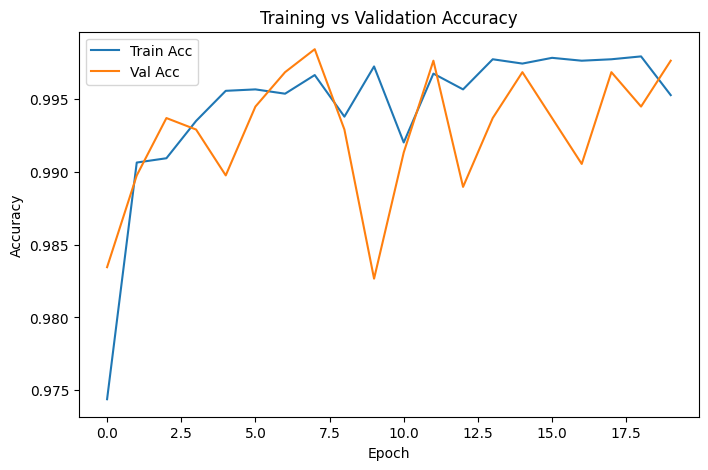

In [10]:
plt.figure(figsize=(8,5))
plt.plot(train_hist, label='Train Acc')
plt.plot(val_hist, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()
